# 3. Experiments

In [1]:
from src.environments import MontyHallEnv, MontyHallDiscreteWrapper
from src.rl import QLearningConfig, QLearningAgent

import os
import gymnasium as gym
from gymnasium.envs.registration import register
import wandb
import numpy as np
import matplotlib.pyplot as plt

# Environments defined with Gymnasium
Recall that Reinforcement Learning needs an environment to act in. It takes actions in this environment, learning what the optimal action is for each environment state it observes based on a reward it receives. Environments are independent of the algorithm being used.

`Gymnasium` (https://gymnasium.farama.org/index.html) is the most popular library for defining environment classes and provides a lot of helpful wrappers, as well as an unified and clearly defined interface that all environments follow. It is a fork (continuation) of OpenAI's `Gym`, note that the original `Gym` is no longer maintained by anyone. Sometimes, people refer to `Gym` when they mean `Gymnasium` as a shorthand, or in older posts/literature used `Gym` when it was the main library.

Here, we intend to run the environment initially, to get a feel for how our implemented algorithm (Tabular Q Learning) works in practice with the Gymnasium interface on a provided environment, Monty Hall.

# Monty Hall environment
The Monty Hall is a well-known problem that originated from a game show, it can be stated as follows:
> Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a car; behind the others, goats. You pick a door, say No. 1, and the host, who knows what's behind the doors, opens another door, say No. 3, which has a goat. He then says to you, "Do you want to pick door No. 2?" Is it to your advantage to switch your choice?

<p align="center">
  <img src="assets/monty_hall.png" alt="Monty Hall Environment" />
</p> 

Overall in this notebook, our aim is to learn whether it is optimal or not to actually switch or remain. We can see this by rolling out our policy.

You can also play this environment yourself in the notebook: `notebooks/extra/play_monty_hall.ipynb` before proceeding here.

## Creating the configuration for the algorithm, an agent class, and instantiating the environment

In [2]:
# 1) Let us create a default config and default Q Learning Agent
config = QLearningConfig(
    learning_rate=0.1,
    discount_factor=0.99,
    epsilon_start=1.0,
    epsilon_decay=0.9985,
    epsilon_min=0.05,
    max_steps_per_episode=100,
    video_dir="exports/monty_hall",
)

# 2) Create an instance of the Monty Hall environment
register(
    id="MontyHall-v0",
    entry_point="src.environments:MontyHallEnv"
)
env = gym.make(
    "MontyHall-v0",
    n_doors=3,
    n_cars=1,
    render_mode="rgb_array",
)

# 2a) Tabular Q Learning requires a Discrete action space: not MultiDiscrete
env = MontyHallDiscreteWrapper(env)

# 3) An instance of Tabular Q Learning
agent = QLearningAgent(env, config)

# 4) Train for 500 episodes
num_episodes = 500
episode_rewards, converged_episode, converged_time = agent.train(
    episodes=num_episodes,
    log_interval=10,
)

# 4) Print out what happened each episode
for i, r in enumerate(episode_rewards, start=1):
    print(f"Episode {i:2d} → Reward: {r:+.1f}")

if converged_episode != -1:
    print(f"\nConverged at episode {converged_episode} after {converged_time:.2f}s")
else:
    print("\nDid not converge within 10 episodes.")

# 5) See the policy
print("\nRunning 10 test episodes with the trained policy:")
agent.test(episodes=10)

env.close()

/Users/ayouba/Documents/laboratoire/RL/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment MontyHall-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/ayouba/Documents/laboratoire/RL/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
/Users/ayouba/Documents/laboratoire/RL/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /Users/ayouba/Documents/laboratoire/RL/exports/monty_hall folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
2

Episode  1 → Reward: +0.0
Episode  2 → Reward: +1.0
Episode  3 → Reward: +1.0
Episode  4 → Reward: +1.0
Episode  5 → Reward: +1.0
Episode  6 → Reward: +1.0
Episode  7 → Reward: +0.0
Episode  8 → Reward: +0.0
Episode  9 → Reward: +1.0
Episode 10 → Reward: +1.0
Episode 11 → Reward: +0.0
Episode 12 → Reward: +1.0
Episode 13 → Reward: +0.0
Episode 14 → Reward: +0.0
Episode 15 → Reward: +0.0
Episode 16 → Reward: +0.0
Episode 17 → Reward: +0.0
Episode 18 → Reward: +1.0
Episode 19 → Reward: +1.0
Episode 20 → Reward: +0.0
Episode 21 → Reward: +0.0
Episode 22 → Reward: +0.0
Episode 23 → Reward: +1.0
Episode 24 → Reward: +1.0
Episode 25 → Reward: +1.0
Episode 26 → Reward: +0.0
Episode 27 → Reward: +1.0
Episode 28 → Reward: +0.0
Episode 29 → Reward: +0.0
Episode 30 → Reward: +1.0
Episode 31 → Reward: +0.0
Episode 32 → Reward: +1.0
Episode 33 → Reward: +0.0
Episode 34 → Reward: +1.0
Episode 35 → Reward: +0.0
Episode 36 → Reward: +1.0
Episode 37 → Reward: +0.0
Episode 38 → Reward: +1.0
Episode 39 →

# Visualisation of Training
Here, we want to visualise how well our training went in terms of the reward achieved throughout the episodes encountered by our training algorithm. The best way to do this is quite simple: plot the training so far.

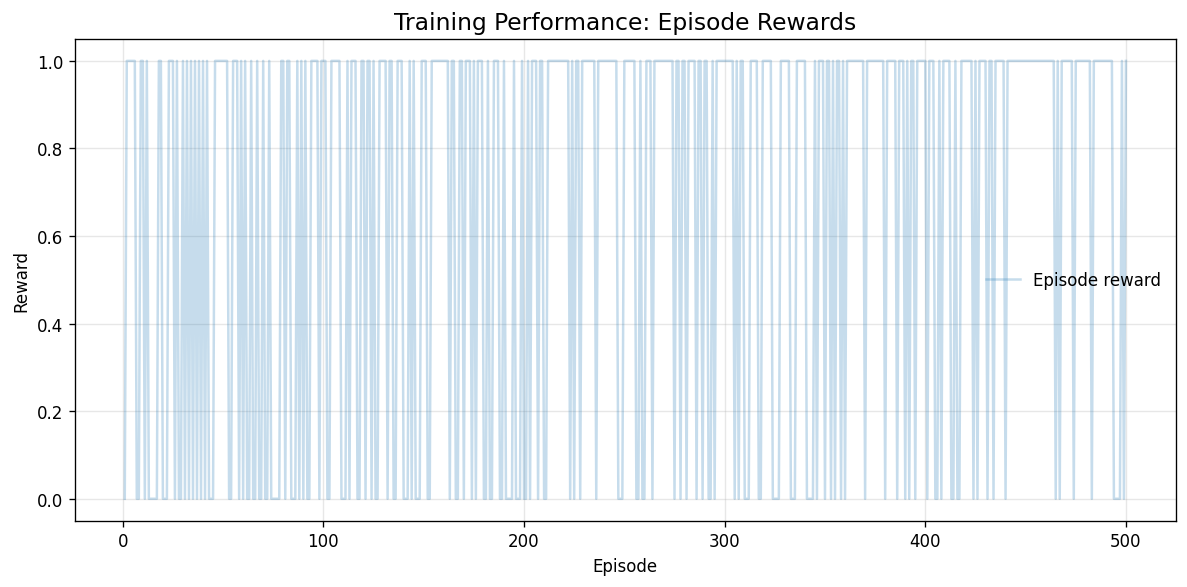

In [3]:
dpi     = 120       # figure resolution

r = np.asarray(episode_rewards, dtype=float)

cumsum = np.cumsum(np.insert(r, 0, 0))
smooth = (cumsum[num_episodes:] - cumsum[:-num_episodes]) / num_episodes
episodes_smooth = np.arange(len(smooth)) + num_episodes//2 + 1

plt.figure(figsize=(10, 5), dpi=dpi)
plt.plot(range(1, len(r) + 1), r, alpha=0.25, label='Episode reward')

plt.title('Training Performance: Episode Rewards', fontsize=14)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Hyperparameter tuning
Some Reinforcement Learning algorithms have an abundance of parameters; especially in the territory of Deep Reinforcement Learning, where you could tune the batch size and even the neural network layout, amongst the learning rate and exploration rate.

Therefore, it is important that we are able to systematically tune these hyperparameters in an automated fashion, as the number of combinations of parameters and interdependent effects are too numerous to manually tune (aside from setting a good starting point). Tuning is an art in and of itself, and is a form of optimization. Luckily, many libraries exist for finding the optimal set of hyperparameters, using various different approaches such as genetic algorithms, in order to explore and exploit areas of the tuning state space that are promising automatically.

## How does it work?
Exactly how hyperparameter tuning chooses to select combinations of parameters, continue runs (also known as *sweeps*, each sweep having an unique combination of parameters) or stop early, is an art in and of itself. There are many methods and algorithms that are out of scope for this project, although it should be noted that we are not simply enumerating all possible parameters as in a grid search, for example instead we can choose to use a random search or Bayes search.

What we define is a tunable parameter, such as the following:
```python
        learning_rate   = dict(min=1e-5,  max=1e-2,  distribution="log_uniform_values"),
```
* **What it is:** a rule for the hyperparameter tuning library, stating it should *try out different learning-rates* during a hyperparameter sweep.
* **The range:** it may pick anything between **0.00001** and **0.01**.
* **How the picks are made:** not evenly spaced, but **log-uniformly**.

  * Think “pick a random exponent” rather than “pick a random number.”
  * Each order of magnitude (10⁻⁵ → 10⁻⁴ → 10⁻³ → 10⁻²) is equally likely.

Why log-uniform?

1. With learning rates, what matters is usually the *order of magnitude*, not the exact decimal.
2. A log-uniform draw therefore spends just as much effort exploring tiny values (which often work best) as it does larger ones.

In short: *“Try lots of learning-rates between 0.000 01 and 0.01, giving every magnitude the same chance, because we don’t yet know which size step the optimiser will like.”*

This is just one tunable parameter, and the problem of hyperparameter tuning is you have to select values for multiple hyperparameters at the same time, where hyperparameters are not always independent of each other, and you have limited compute time to run these experiments in. This is why specialised algorithms exist just for hyperparameter tuning.

## Why is hyperparameter tuning needed?
Finding the best set of hyperparameters allows converging (achieving the optimal/best performance) in a quicker fashion. It is possible that a default set of hyperparameters could converge to an optimal policy, but take 1000 times longer than using a set of optimal hyperparameters. Sometimes, without optimal hyperparameters it can also be easy for the policy to appear it has converged but it has converged to a sub-optimal policy instead of the policy that produces the best reward.

## Weights and Biases
Weights and Biases (referred to commonly as W&B or WandB) is a standard tool used in both industry and academia for tracking (and storing) the results of experiments. In other words, Weights and Biases is an end-to-end developer platform that keeps every experiment, dataset, model checkpoint, and evaluation in a single, searchable workspace.

Specifically, we use it both as a hyperparameter tuning library and storing the results of experiments based on these hyperparameters.

You can find more information at: https://docs.wandb.ai/quickstart/

In [4]:
wandb.login() # See https://docs.wandb.ai/quickstart/

wandb: Currently logged in as: magicayyub (magicayyub-lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
def train_sweep() -> None:
    """  One full training run driven by a set of hyper-parameters coming
    from wandb.config. Logs metrics to W&B at the end of every episode.
    """
    with wandb.init(project="montyhall-ql") as run:
        cfg = run.config

        # 1. Converting the Weight & Biases Config -> Q Learning Config
        qcfg = QLearningConfig(
            learning_rate   = cfg.learning_rate,
            discount_factor = cfg.discount_factor,
            epsilon_start   = 1.0,
            epsilon_decay   = cfg.epsilon_decay,
            epsilon_min     = 0.05,
            max_steps_per_episode = 100,
            video_dir       = None
        )

        # 2️) Create env & agent
        env  = gym.make("MontyHall-v0", n_doors=3, n_cars=1, render_mode=None)
        env  = MontyHallDiscreteWrapper(env)
        agent = QLearningAgent(env, qcfg)

        # 3️) Run training loop
        episode_rewards, converged_ep, converged_t = agent.train(
            episodes     = 500,
            log_interval = 25,
        )

        # 4️) Log summary metrics & clean up
        wandb.log({
            "best_reward"      : max(episode_rewards),
            "converged_episode": converged_ep,
            "train_time_sec"   : converged_t,
        })
        env.close()

In [6]:
sweep_config = dict(
    name   = "montyhall-bayes",
    method = "bayes",                      # The search method used: grid | random | bayes. Random & Bayes work best.
    metric = dict(name="best_reward", goal="maximize"),
    parameters = dict(
        learning_rate   = dict(min=1e-5,  max=1e-2,  distribution="log_uniform_values"),
        discount_factor = dict(min=0.8,   max=0.999, distribution="uniform"),
        epsilon_decay   = dict(min=0.95,  max=0.9999,distribution="uniform"),
    ),
    early_terminate = dict(type="hyperband", min_iter=10),
)

sweep_id = wandb.sweep(sweep_config, project="montyhall-ql")
wandb.agent(sweep_id, function=train_sweep, count=30) # 30 trials

Create sweep with ID: 9cdpki6q
Sweep URL: https://wandb.ai/magicayyub-lab/montyhall-ql/sweeps/9cdpki6q


wandb: Agent Starting Run: mu1uncc2 with config:
wandb: 	discount_factor: 0.8400791994326674
wandb: 	epsilon_decay: 0.968496460539946
wandb: 	learning_rate: 2.2817997105230663e-05


2025-08-30 04:02:17.045 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.449
2025-08-30 04:02:17.047 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.202
2025-08-30 04:02:17.048 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.091
2025-08-30 04:02:17.050 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:02:17.052 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:02:17.054 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:02:17.056 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:02:17.060 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:02:17.062 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,394
train_time_sec,0.03564


wandb: Agent Starting Run: jmuadp1g with config:
wandb: 	discount_factor: 0.9670452556264016
wandb: 	epsilon_decay: 0.9808172294085244
wandb: 	learning_rate: 0.001730099107889011


2025-08-30 04:02:22.452 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.616
2025-08-30 04:02:22.456 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.380
2025-08-30 04:02:22.458 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.234
2025-08-30 04:02:22.460 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.144
2025-08-30 04:02:22.463 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.089
2025-08-30 04:02:22.465 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.055
2025-08-30 04:02:22.468 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:02:22.490 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:02:22.497 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,394
train_time_sec,0.06722


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nv4kgjrk with config:
wandb: 	discount_factor: 0.8683199977078525
wandb: 	epsilon_decay: 0.9853135059665356
wandb: 	learning_rate: 0.00014180088315134888


2025-08-30 04:02:37.881 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.691
2025-08-30 04:02:37.883 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.477
2025-08-30 04:02:37.885 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +0.0 | ε: 0.330
2025-08-30 04:02:37.887 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.228
2025-08-30 04:02:37.889 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.157
2025-08-30 04:02:37.891 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.109
2025-08-30 04:02:37.894 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.075
2025-08-30 04:02:37.897 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.052
2025-08-30 04:02:37.900 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,394
train_time_sec,0.03801


wandb: Agent Starting Run: tp6be3qm with config:
wandb: 	discount_factor: 0.941327967252124
wandb: 	epsilon_decay: 0.970080497029396
wandb: 	learning_rate: 0.002855897614794718


2025-08-30 04:02:43.335 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.468
2025-08-30 04:02:43.337 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.219
2025-08-30 04:02:43.339 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.102
2025-08-30 04:02:43.341 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:02:43.343 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:02:43.345 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:02:43.348 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:02:43.351 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:02:43.353 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,-1
train_time_sec,0


wandb: Agent Starting Run: u778qvhc with config:
wandb: 	discount_factor: 0.995928855241078
wandb: 	epsilon_decay: 0.97748882177289
wandb: 	learning_rate: 0.003433922119192617


2025-08-30 04:02:48.675 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.566
2025-08-30 04:02:48.677 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.320
2025-08-30 04:02:48.679 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.181
2025-08-30 04:02:48.680 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.103
2025-08-30 04:02:48.682 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.058
2025-08-30 04:02:48.684 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:02:48.687 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:02:48.690 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:02:48.692 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,371
train_time_sec,0.04283


wandb: Agent Starting Run: u9y1h3v4 with config:
wandb: 	discount_factor: 0.8417754477991882
wandb: 	epsilon_decay: 0.994785848892426
wandb: 	learning_rate: 0.00021120035604152204


2025-08-30 04:02:54.216 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.877
2025-08-30 04:02:54.219 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.770
2025-08-30 04:02:54.221 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.676
2025-08-30 04:02:54.223 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.593
2025-08-30 04:02:54.225 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +0.0 | ε: 0.520
2025-08-30 04:02:54.228 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.456
2025-08-30 04:02:54.231 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +0.0 | ε: 0.401
2025-08-30 04:02:54.233 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.351
2025-08-30 04:02:54.236 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.308
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,-1
train_time_sec,0


wandb: Agent Starting Run: cpeqoaw0 with config:
wandb: 	discount_factor: 0.8694617745943858
wandb: 	epsilon_decay: 0.9897816980711844
wandb: 	learning_rate: 0.0018856271457838023


2025-08-30 04:02:59.715 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.774
2025-08-30 04:02:59.718 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.598
2025-08-30 04:02:59.721 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.463
2025-08-30 04:02:59.723 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.358
2025-08-30 04:02:59.726 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.277
2025-08-30 04:02:59.729 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.214
2025-08-30 04:02:59.732 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.166
2025-08-30 04:02:59.734 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.128
2025-08-30 04:02:59.736 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.099
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,418
train_time_sec,0.04242


wandb: Agent Starting Run: iqn3hyua with config:
wandb: 	discount_factor: 0.8989651340704169
wandb: 	epsilon_decay: 0.9752259147960564
wandb: 	learning_rate: 6.110667556298384e-05


2025-08-30 04:03:05.299 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.534
2025-08-30 04:03:05.301 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.285
2025-08-30 04:03:05.304 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.152
2025-08-30 04:03:05.305 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.081
2025-08-30 04:03:05.308 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:03:05.310 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:03:05.313 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:03:05.315 | SUCCESS  | src.rl.tabular_q_learning:train:237 - Converged at episode 198 after 0.02s
2025-08-30 04:03:05.315 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,198
train_time_sec,0.01848


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0vswpbdh with config:
wandb: 	discount_factor: 0.8561184172788626
wandb: 	epsilon_decay: 0.9861346611189992
wandb: 	learning_rate: 0.00015554679012431366


2025-08-30 04:03:17.721 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.705
2025-08-30 04:03:17.724 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.498
2025-08-30 04:03:17.726 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.351
2025-08-30 04:03:17.728 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.248
2025-08-30 04:03:17.730 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.175
2025-08-30 04:03:17.733 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.123
2025-08-30 04:03:17.735 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.087
2025-08-30 04:03:17.738 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.061
2025-08-30 04:03:17.741 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,371
train_time_sec,0.03563


wandb: Agent Starting Run: b5lf5xfs with config:
wandb: 	discount_factor: 0.9512216865977045
wandb: 	epsilon_decay: 0.9857180866681654
wandb: 	learning_rate: 0.0014856113438199289


2025-08-30 04:03:20.767 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.698
2025-08-30 04:03:20.769 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.487
2025-08-30 04:03:20.771 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +0.0 | ε: 0.340
2025-08-30 04:03:20.773 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.237
2025-08-30 04:03:20.775 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.166
2025-08-30 04:03:20.778 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.116
2025-08-30 04:03:20.780 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.081
2025-08-30 04:03:20.783 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.056
2025-08-30 04:03:20.785 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,371
train_time_sec,0.03523


wandb: Agent Starting Run: wl2sn1rd with config:
wandb: 	discount_factor: 0.8527477151710785
wandb: 	epsilon_decay: 0.9549870695422712
wandb: 	learning_rate: 0.0023119160298160574


2025-08-30 04:03:26.227 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.316
2025-08-30 04:03:26.229 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.100
2025-08-30 04:03:26.231 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.050
2025-08-30 04:03:26.233 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:03:26.235 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:03:26.238 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:03:26.240 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:03:26.243 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:03:26.245 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,-1
train_time_sec,0


wandb: Agent Starting Run: ywqs88up with config:
wandb: 	discount_factor: 0.8465793670215581
wandb: 	epsilon_decay: 0.9588863963340636
wandb: 	learning_rate: 3.505102171223918e-05


2025-08-30 04:03:31.860 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.350
2025-08-30 04:03:31.862 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.123
2025-08-30 04:03:31.864 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.050
2025-08-30 04:03:31.866 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:03:31.868 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:03:31.868 | SUCCESS  | src.rl.tabular_q_learning:train:237 - Converged at episode 124 after 0.01s
2025-08-30 04:03:31.871 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:03:31.872 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:03:31.875 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,124
train_time_sec,0.01027


wandb: Agent Starting Run: 1pw0tnzc with config:
wandb: 	discount_factor: 0.9844933429454592
wandb: 	epsilon_decay: 0.9834313379196598
wandb: 	learning_rate: 3.552702294546956e-05


2025-08-30 04:03:37.200 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.659
2025-08-30 04:03:37.202 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.434
2025-08-30 04:03:37.204 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.286
2025-08-30 04:03:37.206 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.188
2025-08-30 04:03:37.208 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.124
2025-08-30 04:03:37.211 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.082
2025-08-30 04:03:37.213 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.054
2025-08-30 04:03:37.215 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:03:37.218 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,371
train_time_sec,0.03431


wandb: Agent Starting Run: 50hy4q2o with config:
wandb: 	discount_factor: 0.9167415118527686
wandb: 	epsilon_decay: 0.9685038439375796
wandb: 	learning_rate: 1.649108490004329e-05


2025-08-30 04:03:42.631 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.449
2025-08-30 04:03:42.634 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.202
2025-08-30 04:03:42.636 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.091
2025-08-30 04:03:42.637 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:03:42.640 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:03:42.643 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:03:42.645 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:03:42.648 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:03:42.651 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,-1
train_time_sec,0


wandb: Agent Starting Run: b02edz0g with config:
wandb: 	discount_factor: 0.998659725292557
wandb: 	epsilon_decay: 0.9545668733090228
wandb: 	learning_rate: 9.164429214646904e-05


2025-08-30 04:03:48.232 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.313
2025-08-30 04:03:48.234 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.098
2025-08-30 04:03:48.236 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.050
2025-08-30 04:03:48.238 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:03:48.241 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:03:48.244 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:03:48.247 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:03:48.250 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:03:48.252 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,371
train_time_sec,0.03833


wandb: Agent Starting Run: 7fu79zkt with config:
wandb: 	discount_factor: 0.9833026547312592
wandb: 	epsilon_decay: 0.9864761207689656
wandb: 	learning_rate: 0.005546639431366208


2025-08-30 04:03:53.661 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.711
2025-08-30 04:03:53.663 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.506
2025-08-30 04:03:53.666 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.360
2025-08-30 04:03:53.668 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.256
2025-08-30 04:03:53.671 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.182
2025-08-30 04:03:53.673 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.130
2025-08-30 04:03:53.675 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.092
2025-08-30 04:03:53.698 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.066
2025-08-30 04:03:53.727 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,350
train_time_sec,0.10808


wandb: Agent Starting Run: 11sizisp with config:
wandb: 	discount_factor: 0.8877732343880096
wandb: 	epsilon_decay: 0.986862137764578
wandb: 	learning_rate: 0.00014948546056284964


2025-08-30 04:03:59.042 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.718
2025-08-30 04:03:59.044 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.516
2025-08-30 04:03:59.046 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.371
2025-08-30 04:03:59.048 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.266
2025-08-30 04:03:59.051 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.191
2025-08-30 04:03:59.053 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.138
2025-08-30 04:03:59.055 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.099
2025-08-30 04:03:59.062 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.071
2025-08-30 04:03:59.112 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.051
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,371
train_time_sec,0.09836


wandb: Agent Starting Run: 9lwr9qub with config:
wandb: 	discount_factor: 0.8492205919689418
wandb: 	epsilon_decay: 0.952524092534295
wandb: 	learning_rate: 4.033598343433779e-05


2025-08-30 04:04:04.690 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.296
2025-08-30 04:04:04.692 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.088
2025-08-30 04:04:04.694 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.050
2025-08-30 04:04:04.696 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:04:04.698 | SUCCESS  | src.rl.tabular_q_learning:train:237 - Converged at episode 122 after 0.01s
2025-08-30 04:04:04.698 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:04:04.700 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:04:04.702 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:04:04.704 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,122
train_time_sec,0.01002


wandb: Agent Starting Run: qq22gw1f with config:
wandb: 	discount_factor: 0.99654716624568
wandb: 	epsilon_decay: 0.99729914522371
wandb: 	learning_rate: 0.00010505978619564636


2025-08-30 04:04:10.138 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.935
2025-08-30 04:04:10.141 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +0.0 | ε: 0.874
2025-08-30 04:04:10.142 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +0.0 | ε: 0.816
2025-08-30 04:04:10.145 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.763
2025-08-30 04:04:10.147 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +0.0 | ε: 0.713
2025-08-30 04:04:10.150 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.667
2025-08-30 04:04:10.153 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +0.0 | ε: 0.623
2025-08-30 04:04:10.156 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.582
2025-08-30 04:04:10.159 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.544
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,-1
train_time_sec,0


wandb: Agent Starting Run: ez0qeale with config:
wandb: 	discount_factor: 0.8350338492104857
wandb: 	epsilon_decay: 0.9673575045227804
wandb: 	learning_rate: 0.0005253362232872264


2025-08-30 04:04:15.780 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.436
2025-08-30 04:04:15.782 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.190
2025-08-30 04:04:15.784 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.083
2025-08-30 04:04:15.786 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:04:15.788 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:04:15.790 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:04:15.793 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:04:15.795 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:04:15.798 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,394
train_time_sec,0.03835


wandb: Agent Starting Run: 40uditii with config:
wandb: 	discount_factor: 0.9270581880218672
wandb: 	epsilon_decay: 0.9502784557846398
wandb: 	learning_rate: 0.007049932427536052


2025-08-30 04:04:21.249 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.279
2025-08-30 04:04:21.251 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.078
2025-08-30 04:04:21.252 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.050
2025-08-30 04:04:21.254 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:04:21.256 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:04:21.257 | SUCCESS  | src.rl.tabular_q_learning:train:237 - Converged at episode 125 after 0.01s
2025-08-30 04:04:21.259 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:04:21.260 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:04:21.262 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,125
train_time_sec,0.00971


wandb: Agent Starting Run: fb05hhea with config:
wandb: 	discount_factor: 0.8566606001010512
wandb: 	epsilon_decay: 0.9514683469197894
wandb: 	learning_rate: 0.00010871936556104013


2025-08-30 04:04:26.650 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.288
2025-08-30 04:04:26.652 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.083
2025-08-30 04:04:26.654 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.050
2025-08-30 04:04:26.656 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:04:26.658 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:04:26.661 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:04:26.663 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:04:26.666 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:04:26.669 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,418
train_time_sec,0.04188


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x71qpg1s with config:
wandb: 	discount_factor: 0.8145324245576678
wandb: 	epsilon_decay: 0.9940144159865136
wandb: 	learning_rate: 9.923307562517556e-05


2025-08-30 04:04:58.894 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.861
2025-08-30 04:04:58.896 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.741
2025-08-30 04:04:58.898 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.637
2025-08-30 04:04:58.901 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.549
2025-08-30 04:04:58.903 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.472
2025-08-30 04:04:58.905 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.406
2025-08-30 04:04:58.908 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.350
2025-08-30 04:04:58.911 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.301
2025-08-30 04:04:58.914 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.259
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,-1
train_time_sec,0


wandb: Agent Starting Run: hbg56l1q with config:
wandb: 	discount_factor: 0.9297118937102388
wandb: 	epsilon_decay: 0.954489880569196
wandb: 	learning_rate: 0.0023139082534035806


2025-08-30 04:05:03.282 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.312
2025-08-30 04:05:03.285 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.097
2025-08-30 04:05:03.286 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.050
2025-08-30 04:05:03.288 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:05:03.290 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:05:03.292 | SUCCESS  | src.rl.tabular_q_learning:train:237 - Converged at episode 144 after 0.01s
2025-08-30 04:05:03.293 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:05:03.294 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:05:03.297 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,144
train_time_sec,0.01268


wandb: Agent Starting Run: ebj6h60t with config:
wandb: 	discount_factor: 0.9672918844957704
wandb: 	epsilon_decay: 0.9542751511522444
wandb: 	learning_rate: 0.0041115370967456325


2025-08-30 04:05:08.774 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.310
2025-08-30 04:05:08.776 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.096
2025-08-30 04:05:08.778 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.050
2025-08-30 04:05:08.779 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:05:08.782 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:05:08.784 | SUCCESS  | src.rl.tabular_q_learning:train:237 - Converged at episode 144 after 0.01s
2025-08-30 04:05:08.784 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:05:08.786 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:05:08.788 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,144
train_time_sec,0.01262


wandb: Agent Starting Run: 4dadvjvf with config:
wandb: 	discount_factor: 0.9843251331321043
wandb: 	epsilon_decay: 0.967536274891521
wandb: 	learning_rate: 0.004959137756844828


2025-08-30 04:05:14.189 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +0.0 | ε: 0.438
2025-08-30 04:05:14.192 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.192
2025-08-30 04:05:14.193 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.084
2025-08-30 04:05:14.195 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:05:14.198 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:05:14.200 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:05:14.202 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:05:14.205 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-30 04:05:14.208 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.050
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,418
train_time_sec,0.04049


wandb: Agent Starting Run: zz0h8dvy with config:
wandb: 	discount_factor: 0.9036131124414029
wandb: 	epsilon_decay: 0.9987949853259755
wandb: 	learning_rate: 0.001189759163506245


2025-08-30 04:05:19.622 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.970
2025-08-30 04:05:19.624 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.941
2025-08-30 04:05:19.627 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.914
2025-08-30 04:05:19.629 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.886
2025-08-30 04:05:19.631 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.860
2025-08-30 04:05:19.634 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.835
2025-08-30 04:05:19.636 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +0.0 | ε: 0.810
2025-08-30 04:05:19.640 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.786
2025-08-30 04:05:19.642 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.762
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,-1
train_time_sec,0


wandb: Agent Starting Run: ieqfw1w9 with config:
wandb: 	discount_factor: 0.883466171607968
wandb: 	epsilon_decay: 0.9879516238775412
wandb: 	learning_rate: 0.0013371873682120866


2025-08-30 04:05:25.110 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.739
2025-08-30 04:05:25.113 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.545
2025-08-30 04:05:25.114 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.403
2025-08-30 04:05:25.116 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.298
2025-08-30 04:05:25.118 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.220
2025-08-30 04:05:25.121 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.162
2025-08-30 04:05:25.123 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.120
2025-08-30 04:05:25.125 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.089
2025-08-30 04:05:25.128 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   225 | R: +1.0 | ε: 0.065
2025-08-30

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,-1
train_time_sec,0


wandb: Agent Starting Run: m56bothu with config:
wandb: 	discount_factor: 0.8700822497375661
wandb: 	epsilon_decay: 0.9532408158987464
wandb: 	learning_rate: 0.0039645082932469


2025-08-30 04:05:30.644 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.302
2025-08-30 04:05:30.647 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.091
2025-08-30 04:05:30.649 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.050
2025-08-30 04:05:30.650 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:05:30.652 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:05:30.653 | SUCCESS  | src.rl.tabular_q_learning:train:237 - Converged at episode 125 after 0.01s
2025-08-30 04:05:30.655 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:05:30.656 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:05:30.658 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,125
train_time_sec,0.01034


wandb: Agent Starting Run: 37qzbn6y with config:
wandb: 	discount_factor: 0.9299151855704644
wandb: 	epsilon_decay: 0.9639710577884224
wandb: 	learning_rate: 0.00081330456995281


2025-08-30 04:05:36.049 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    25 | R: +1.0 | ε: 0.400
2025-08-30 04:05:36.051 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    50 | R: +1.0 | ε: 0.160
2025-08-30 04:05:36.053 | INFO     | src.rl.tabular_q_learning:train:226 - Episode    75 | R: +1.0 | ε: 0.064
2025-08-30 04:05:36.055 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   100 | R: +1.0 | ε: 0.050
2025-08-30 04:05:36.057 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   125 | R: +1.0 | ε: 0.050
2025-08-30 04:05:36.059 | SUCCESS  | src.rl.tabular_q_learning:train:237 - Converged at episode 144 after 0.01s
2025-08-30 04:05:36.060 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   150 | R: +1.0 | ε: 0.050
2025-08-30 04:05:36.062 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   175 | R: +1.0 | ε: 0.050
2025-08-30 04:05:36.064 | INFO     | src.rl.tabular_q_learning:train:226 - Episode   200 | R: +1.0 | ε: 0.050
2025-08-

best_reward,▁
converged_episode,▁
train_time_sec,▁
best_reward,1
converged_episode,144
train_time_sec,0.01293


# Viewing the results
If you navigate to the sweep URL on Weights & Biases (wandb.ai), you'll see the data logged in various formats such as table and graphs, where you can visualise the hyperparameter space. You should see something like the following:

![wandb dashboard](assets/wandb.png)

Explore this dashboard fully for more information on how the tuning and sweeps went.

We can programmatically print the best hyperparameters as below:

In [7]:
api   = wandb.Api()
sweep = api.sweep(f"{os.getenv("WANDB_ENTITY")}/montyhall-ql/{sweep_id}")
best  = max(sweep.runs, key=lambda r: r.summary.get("best_reward", float("-inf")))



# ── 2. Rank runs: highest reward FIRST, then earliest convergence ────────
def sort_key(run):
    # Reward: want *larger* → negate so larger becomes “smaller” for sort()
    reward = -run.summary.get("best_reward", float("-inf"))
    # Convergence episode: want *smaller*
    conv_ep = run.summary.get("converged_episode", float("inf"))
    return (reward, conv_ep)

best_run = min(sweep.runs, key=sort_key)

# ── 3. Print the winner’s details ────────────────────────────────────────
print(f"🏆  {best_run.name}")
print(f"   • best_reward       : {best_run.summary['best_reward']}")
print(f"   • converged_episode : {best_run.summary['converged_episode']}")
print(f"   • hyperparams:", {k: best_run.config[k] for k in ('learning_rate',
                                                    'discount_factor',
                                                    'epsilon_decay')})

🏆  wise-sweep-4
   • best_reward       : 1
   • converged_episode : -1
   • hyperparams: {'learning_rate': 0.002855897614794718, 'discount_factor': 0.941327967252124, 'epsilon_decay': 0.970080497029396}


# Conclusion

In this notebook, we learnt the following:
* Instantiating environments with the Gymnasium library
* Deployed our previously implemented Reinforcement Learning algorithm, Tabular Q Learning, on the aforementioned environment 
* How to visualise training performance through plotting with Matplotlib
* How to perform hyperparameter tuning
* Followed best practices for experiment tracking and storage of results in an archival manner

Following this notebook, we will learn the process of environment creation in Notebook 4. This allows solving any arbitrary combinatorial problem, allowing you to formally define a model of the "problem space" for any problem you can think of.

# Extension
---

## Extension 1. Optimal General Solution to Monty Hall
As an extension to this, you can consider the following task:
> Based on our trained RL algorithm, using optimal hyperparameters above, how often is it optimal to switch or stay with the first selected door? 

You can do this by using the `.test()` method and collecting some basic statistics using the rolled-out policy.